# Language and Topic models

Objectives:
- visualizing unigram models together
- implementing smoothing
- ranking with probabilistics model
- topic modelling with few lines of code

A common suggestion to users for coming up with good queries is to think of words that would likely appear in a relevant document, and to use those words as the query. The language modeling approach to IR directly models this idea: a document is a good match to a query if the document model is likely to generate the query, which will in turn happen if the document contains the query words often. 

Today we will score documents with respect to user query using language models and also get some experience with topic modelling.

## Loading the data

We use the dataset we already used once - [this topic-modeling dataset](https://code.google.com/archive/p/topic-modeling-tool/downloads) ([or from github](https://github.com/IUCVLab/information-retrieval/blob/main/datasets/topic-modelling.zip)).

In [1]:
import os

from xdg.Config import language


def read_dataset(file_path):
	docs = []
	with open(file_path) as fp:
		for cnt, line in enumerate(fp):
			docs.append(line)
	return docs


# folder with topic files
folder = "../datasets/topic-modelling"

fuel_data = read_dataset(os.path.join(folder, "testdata_news_fuel_845docs.txt"))
brain_inj_data = read_dataset(os.path.join(folder, "testdata_braininjury_10000docs.txt"))
economy_data = read_dataset(os.path.join(folder, "testdata_news_economy_2073docs.txt"))
music_data = read_dataset(os.path.join(folder, "testdata_news_music_2084docs.txt"))

all_data = fuel_data + brain_inj_data + economy_data + music_data

In [2]:
data_ranges = [("fuel", len(fuel_data)),
			   ("brain_injury", len(fuel_data) + len(brain_inj_data)),
			   ("economy", len(fuel_data) + len(brain_inj_data) + len(economy_data)),
			   ("music", len(all_data))]


def get_doc_category(doc_id, ranges):
	for r in ranges:
		if doc_id < r[1]:
			return r[0]
	return "out of range"


print("# of documents:", len(all_data))
assert len(all_data) == 15002
print("data ranges:", data_ranges)
all_data[0][:300] + "..."

# of documents: 15002
data ranges: [('fuel', 845), ('brain_injury', 10845), ('economy', 12918), ('music', 15002)]


'the new york times said editorial for tuesday jan new year day has way stealing down upon coming the shadow the christmas week and its own scintillating eve you celebrated midnight last night was easy little illusory think the festivities gesture dismissal warding off the old year and its associated...'

## Ranking Using Language Models
Our goal is to rank documents by $P(d|q)$, where the probability of a document is interpreted as the likelihood that it is relevant to the query. 

Using Bayes rule: $P(d|q) = \frac{P(q|d)P(d)}{P(q)}$

$P(q)$ is the same for all documents, and so can be ignored. The prior probability of a document $P(d)$ is often treated as uniform across all $d$'s and so it can also be ignored. What does it mean? 

It means that computing $P(q|d)$ for different documents we can compare how relevant are they to the query. How can we estimate $P(q|d)$?

$P(q|d)$ can be estimated as:

![](https://i.imgur.com/BEIMAC1.png)

where $M_d$ is the language model of document $d$, $tf_{t,d}$ is the term frequency of term $t$ in document $d$, and $L_d$ is the number of tokens in document $d$. That is, we just count up how often each word occurred, and divide by the total number of words in the document $d$.

### Build TDM (or DTM)

The first thing we need to do is to build a term-document matrix for tour dataset. Use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for this purpose.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# TODO: build term-document matrix for the dataset


vectorizer = CountVectorizer(analyzer='word', stop_words='english')  # TODO vectorizer with stopwords
counts_data = vectorizer.fit_transform(all_data)  # fit
terms = vectorizer.get_feature_names_out()  # names of dimensions

print("vocabulary size", len(terms))


vocabulary size 92067


Let us visualize the dataset in general, and it's topic parts

['said' 'new' 'patients' 'year' 'injury' 'york' 'years' 'news' 'time'
 'brain' 'people' 'like' 'times' 'atlanta' 'bush' 'service' 'enron' 'just'
 'percent' 'world']


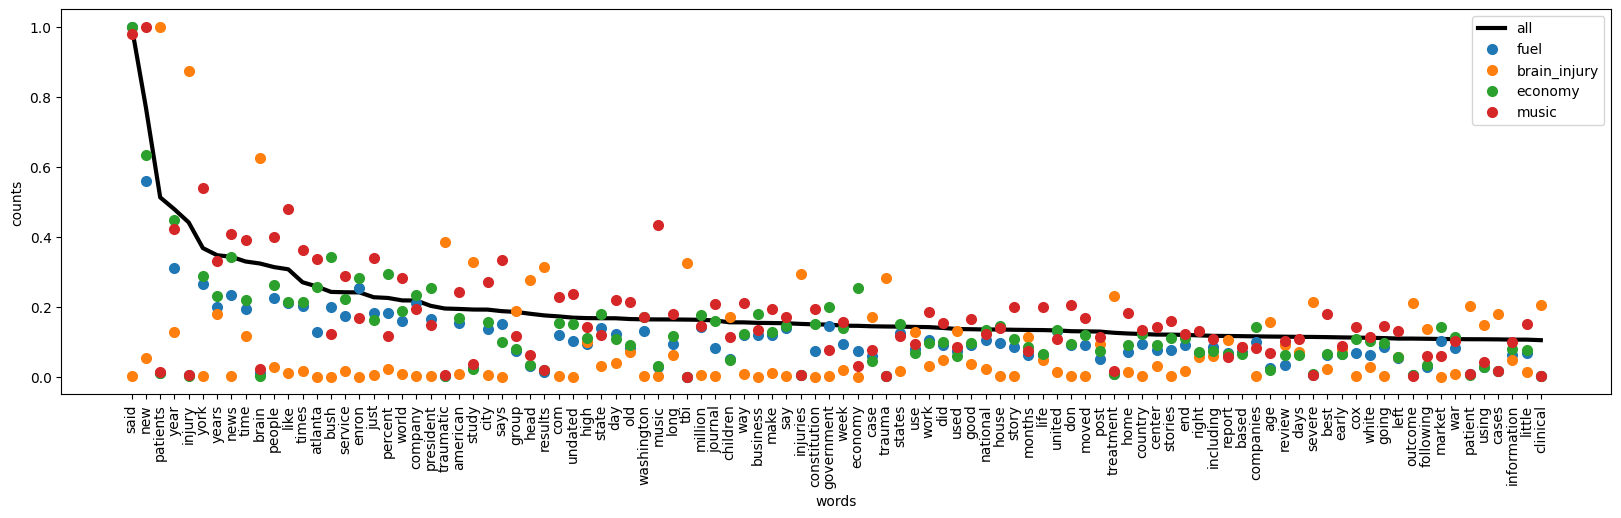

In [13]:
import matplotlib.pyplot as plt
import numpy as np

counts_total = counts_data.sum(axis=0).A1
indices = np.argsort(counts_total)[::-1]
print(np.array(terms)[indices][:20])

plt.figure(figsize=(20, 5))
MAX = 100
plt.plot(counts_total[indices][:MAX] / counts_total[indices[0]], label='all', lw=3, c='black')

for i in range(len(data_ranges)):
	low = data_ranges[i - 1][1] if i > 0 else 0
	high = data_ranges[i][1]
	text = data_ranges[i][0]
	counts = counts_data[low:high].sum(axis=0).A1
	plt.plot(counts[indices][:MAX] / max(counts), label=text, ls='', markersize=7, marker="o")

plt.xlabel("words")
plt.ylabel("counts")
plt.xticks(range(MAX), np.array(terms)[indices[:MAX]], rotation=90)
plt.legend()

**TODO**: discuss the observations:
- Why does the curve (line) look like this?
- What does a circle below and beyond the line mean?
- What does the biggest values mean? Why aren't they the same?
- We discussed that there are such words in the language, which are almost everythere. Where are they?

### Smoothing

Now, you need to implement the abovementioned logic in the `lm_rank_documents` function below. Do you see any potential problems?

Yes, data sparsity - we don't expect to meet each term in each doc, so, in most cases, we will get zero scores, which is not what we really want.

The solution is smooting.

One option is *[additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)* - adding a small number (0 to 1) to the observed counts and renormalizing to give a probability distribution.

Another option is called [Jelinek-Mercer smoothing](http://mlwiki.org/index.php/Smoothing_for_Language_Models#Jelinek-Mercer_Smoothing) - a simple idea that works well in practice is to use a mixture between a document-specific distribution and distribution estimated from the entire collection:

![](https://i.imgur.com/8Qv41Wp.png)

where $0 < λ < 1$ and $M_c$ is a language model built from the entire document collection.

Refer to [*Chapter 12*](https://nlp.stanford.edu/IR-book/html/htmledition/language-models-for-information-retrieval-1.html) for the detailed explanation.


You are going to apply both in your `lm_rank_documents` function. This function takes TDM or DTM as an input, and ranks all documents "building" a language model for each document, returning relative probabilities of query being generated by a document as a document's score.

In [111]:
import numpy as np


def lm_rank_documents(query, tdm, terms_list, smoothing='additive', param=0.001):
	# The function scores documents in tdm using document's language model
	# We implement two types of smoothing. 
	# The function looks up term frequencies in tdm,
	# and returns document scores in a convenient form.
	# @param -- is alpha for additive / lambda for jelinek-mercer
	"""
	:param query: dict, term:count            
	:param tdm: term-document matrix
	:param terms_list: vocabulary list
	:param smoothing: which smoothing to apply, either 'additive' or 'jelinek-mercer'
	:param param: alpha for additive / lambda for jelinek-mercer
	:return: list of scores, list of doc_ids sorted by their scores 
	"""
	n_docs = tdm.shape[0]
	doc_lengths = tdm.sum(axis=1)
	len_collection = np.sum(doc_lengths)
	scores = np.zeros(n_docs)
	for term in query.keys():
		# check if term exists
		if term in terms_list:
			# get term's id
			term_id = np.where(terms_list == term)[0][0]
		else:
			continue
		query_tf = query[term]
		# calculate collection frequency of a term
		collection_tf = np.sum(tdm[:, term_id])
		for doc_id in range(n_docs):
			doc_tf = tdm[doc_id, term_id]
			# apply smoothing of any
			if smoothing == 'additive':
				doc_score_factor = (doc_tf + param) / (doc_lengths[doc_id] + param * len(terms_list))
			elif smoothing == 'jelinek':

				# TODO #####################################################################
				# complete the formula here:
				# lambda = param
				# in-document probability is a "doc tf" / "doc length"
				# in-language probability is a "collection tf" / "collection length"
				###########################################################################  
				doc_prob = doc_tf / (doc_lengths[doc_id])
				doc_prob *= param
				
				language_prob = collection_tf / len_collection
				language_prob *= (1 - param)
				
				doc_score_factor = doc_prob + language_prob
			else:
				doc_score_factor = doc_tf / doc_lengths[doc_id]

			doc_score_factor = doc_score_factor ** query_tf

			if doc_id not in scores:
				scores[doc_id] = 1
			# accumulate scores
			scores[doc_id] *= doc_score_factor
	# sorts doc_ids by scores
	sorted_doc_ids = np.argsort(-scores)
	return scores, sorted_doc_ids

### Testing

Check if this type of ranking gives meaningful results. For each query output document `category`, `doc_id`, `score`, and the *beginning* of the document, as it is shown below. Analyze if categories and contents match the queries. 

In [112]:
# !pip show nltk

In [113]:
# !pip install nltk

In [114]:
from collections import Counter
from nltk.corpus import stopwords
from nltk import word_tokenize, download
import string

# download('stopwords')
# download('punkt')

In [115]:
def prepare_query(raw_query):
	stop_words = list(string.punctuation) + stopwords.words('english')
	return Counter([i for i in word_tokenize(raw_query.lower()) if i not in stop_words])


def process_query(raw_query, counts_data, terms, data_ranges, smoothing):
	# TODO process user query and print search 
	# results including 
	# document category, id, score, and some part of its work
	query = prepare_query(raw_query)
	print("user query:", '\033[95m' + raw_query + '\033[0m', "~", query.most_common())
	doc_scores, doc_ids_sorted = lm_rank_documents(query, counts_data, terms, smoothing='jelinek', param=0.01)
	print("\nsearch results:")
	for i in range(5):
		doc_id = doc_ids_sorted[i]
		print(
			f'\033[1m{get_doc_category(doc_id, data_ranges)}\033[0m#{doc_id} score={doc_scores[doc_id]:.5f} | {all_data[doc_id][:100]}...')


user_queries = ["piano concert", "symptoms of head trauma", "wall street journal"]
print("jelinek smoothing results:")
for q in user_queries:
	process_query(q, counts_data, terms, data_ranges, "jelinek")
	print("\n")

print()
print("additive smoothing results:")
for q in user_queries:
	process_query(q, counts_data, terms, data_ranges, "additive")
	print("\n")

jelinek smoothing results:
user query: piano concert ~ [('piano', 1), ('concert', 1)]


/tmp/ipykernel_88101/1054930439.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores[doc_id] *= doc_score_factor



search results:
brain_injury#6666 score=0.00028 | medical legal issues fetal monitoring despite almost universal fetal monitoring during labor debates...
music#13167 score=0.00026 | dayton ohio rate genre pop artist various artists title the concert for new york city when the world...
music#13330 score=0.00025 | atlanta prominent midtown intersection one step closer becoming major cultural landmark the atlanta ...
economy#11335 score=0.00025 | atlanta prominent midtown intersection one step closer becoming major cultural landmark the atlanta ...
music#12926 score=0.00024 | felt like was going church marry guy never met said the jazz violinist regina carter the metaphorica...


user query: symptoms of head trauma ~ [('symptoms', 1), ('head', 1), ('trauma', 1)]

search results:
brain_injury#1833 score=0.01110 | trauma 
...
brain_injury#5956 score=0.00610 | head trauma 
...
brain_injury#9585 score=0.00444 | imaging head trauma 
...
brain_injury#2448 score=0.00444 | ocular trauma and glau

**TODO:**
- Discuss results for the search. What do you see?
- Discuss implementation of the methods. Can you do faster? Can we use vector indices? Graph-based indices?

## Topic modeling

Now let's use *Latent Dirichlet Allocation* to identify topics in this collection and check if they match the original topics (fuel, economy, etc.). Go through the tutorial [here](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) and apply the ideas there to our dataset. 

In [117]:
# TODO: apply LDA to our dataset and output the resulting categories 
from sklearn.decomposition import LatentDirichletAllocation as LDA


# Helper function
def print_topics(model, count_vectorizer, n_top_words=15):
	words = count_vectorizer.get_feature_names_out()
	print(words)
	for topic_idx, topic in enumerate(model.components_):
		print("\nTopic #%d:" % topic_idx)
		print(" ".join([words[i]
						for i in topic.argsort()[:-n_top_words - 1:-1]]))


number_topics = 4
lda = LDA(n_components=number_topics)  # TODO your code here!!!
lda.fit(counts_data)

LatentDirichletAllocation(n_components=4)

In [118]:
print("Topics found via LDA:")
print_topics(lda, vectorizer)

Topics found via LDA:
['000l' '000m' '000th' ... 'zywicki' 'zzzz' 'zzzzs']

Topic #0:
said year new like time people just percent music says company years million don way

Topic #1:
new york news atlanta enron times service undated journal constitution moved com washington stories cox

Topic #2:
patients injury brain traumatic study tbi results injuries trauma head treatment severe outcome clinical patient

Topic #3:
said bush president new government year people state states years united house economy officials war


We expect to see something like this, not exactly but kind of (if collapsed, click on 3 dots):

```
Topic #0:
brain injury patients tbi traumatic study cerebral results severe group cognitive clinical pressure imaging following outcome control using children test

Topic #1:
new said york news atlanta like times year service time people undated just music journal constitution city says com years

Topic #2:
patients injury injuries trauma head study results traumatic brain treatment cases patient fractures years case outcome methods clinical tbi surgery

Topic #3:
said year bush percent new enron company president government people economy years million state companies states economic united time billion
```